In [1]:
from warnings import simplefilter

import numpy as np
import pandas as pd
from scipy.stats import linregress, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tqdm.notebook import tqdm

import plot
from select_complex import Constraints, get_top_structure


simplefilter(action='ignore', category=FutureWarning)
tqdm.pandas()


DGE_FILE = '../data/dge/dge.txt'
MRNA_SEQ_FILE = '../data/seqs/utr_seqs.fa'
SITES_FILE = '../results/site_predictions/sites.txt'

STRUCT_DIR = '../results/RNAsubopt/'
FIG_DIR = '../results/graphs/FIG6/'

DIST_PALETTE = ['#000000', '#023eff', '#00d7ff', '#f14cc1', '#e8000b']

## Structure prediction

In [2]:
# Genes with =1 site
data = pd.read_csv(DGE_FILE, sep='\t')
sites = pd.read_csv(SITES_FILE, sep='\t')
data = pd.merge(data, sites)
data.drop_duplicates(subset='Gene ID', keep=False, inplace=True)
# Genes downregulated by 34aWT
data = data[(data['log2fc WT-NC'] < 0) & (data['FDR WT-NC'] < 0.05)]

# Predict structures
constraints = Constraints(
    force_paired=({13}, {14},),
    min_pairs=3, offset=(-4, 4), no_gu=True, max_mm_count=0)
cols = ['3P start', 'Target pairs', 'miRNA pairs', 'MFE', 'Offset', 'GU pairs']
data[cols] = data.progress_apply(
    get_top_structure, args=(STRUCT_DIR, constraints,), axis=1)

# Categorize offsets (zero, negative, positive)
data['Offset group'] = data['Offset'].apply(
    lambda x: '0' if x == 0 else '-' if x < 0 else '+' if x > 0
    else 'No 3P')

  0%|          | 0/1052 [00:00<?, ?it/s]

## Fig. 6A

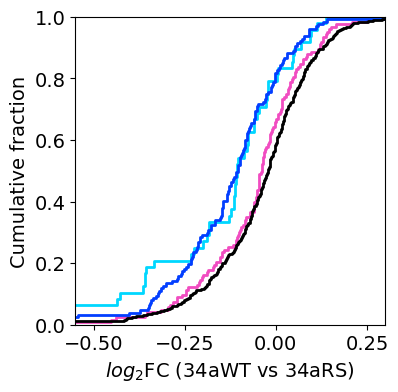

p = 1.9e-10 (ANOVA)

group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     +      -  -0.0698 0.0025 -0.1206 -0.0189   True
     +      0  -0.0863 0.0066 -0.1548 -0.0179   True
     +  No 3P   0.0174 0.6613 -0.0217  0.0565  False
     -      0  -0.0166 0.9235 -0.0847  0.0515  False
     -  No 3P   0.0872    0.0  0.0486  0.1257   True
     0  No 3P   0.1038 0.0001  0.0439  0.1636   True


  Offset group  count
0        No 3P    754
1            -    127
3            0     48
2            +    123


<Figure size 400x400 with 0 Axes>

In [3]:
x_var = 'log2fc WT-RS'
hue = 'Offset group'
groups = ['No 3P', '-', '0', '+']

plot.cumulative_hist(
    data, x=x_var, hue=hue, hue_order=groups, palette = DIST_PALETTE[:-1],
    xlim=(-0.55, 0.3), xticks=(-0.5, 0.25, 0.25),
    xlabel='$log_{2}$FC (34aWT vs 34aRS)',
    outfile=FIG_DIR+'6A')

model = f_oneway(*[data[data[hue] == i][x_var] for i in groups])
print('p =', plot.round_value(model.pvalue, 2), '(ANOVA)\n')

hsd = pairwise_tukeyhsd(endog=data[x_var], groups=data[hue], alpha=0.05)
print(*str(hsd.summary()).split('\n')[2:-1], sep='\n')
print('\n')

counts = data[hue].value_counts().reset_index()
counts.sort_values(hue, key=np.vectorize(groups.index), inplace=True)
print(counts)

## Fig. 6B

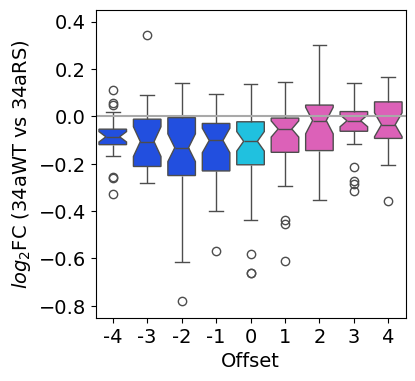

   Offset  count
8    -4.0     22
6    -3.0     25
2    -2.0     43
3    -1.0     37
0     0.0     48
1     1.0     44
4     2.0     29
5     3.0     27
7     4.0     23


<Figure size 400x400 with 0 Axes>

In [4]:
data.dropna(subset='3P start', inplace=True)

offsets = sorted(list(set(data['Offset'].tolist())))

palette = ['#023eff']*4+['#00d7ff']+['#f14cc1']*4
plot.box(data=data, x='Offset', y='log2fc WT-RS', order=offsets,
                 palette=palette, xlabel='Offset', hlines=[0],
                 xticks=(0, 8, 1), xticklabels=list(range(-4, 5)),
                 figsize=(4, 4), ylabel='$log_{2}$FC (34aWT vs 34aRS)',
                 ylim=(-0.85, 0.45), yticks=(-0.8, 0.4, 0.2),
                 outfile=FIG_DIR+'6B')

counts = data['Offset'].value_counts().reset_index()
counts.sort_values('Offset', key=np.vectorize(offsets.index), inplace=True)
print(counts)

## Structure prediction

In [5]:
# Genes with >=1 site
data = pd.read_csv(DGE_FILE, sep='\t')
sites = pd.read_csv(SITES_FILE, sep='\t')
data = pd.merge(data, sites)

# Predict structures with zero or negative offset
constraints = Constraints(
    force_paired=({13}, {14},),
    min_pairs=3, offset=(-2, 1), no_gu=True, max_mm_count=0)
data['3P 1'] = data.progress_apply(
    get_top_structure, args=(STRUCT_DIR, constraints, True), axis=1)

# Predict structures with positive offset for remaining sites 
constraints = Constraints(
    force_paired=({13}, {14},),
    min_pairs=3, offset=(-4, 4), no_gu=True, max_mm_count=0)
data['3P 2'] = data.progress_apply(
    get_top_structure, args=(STRUCT_DIR, constraints, True), axis=1)

# Rank the predictions and merge
data['3P'] = data.apply(
    lambda x: 1 if x['3P 1'] == True else 2 if x['3P 2'] == True
    else 3, axis=1)

# Sort by prediction rank and keep first instance of each Gene ID
data.sort_values(by='3P', ascending=True, inplace=True)
data.drop_duplicates(subset='Gene ID', keep='first', inplace=True)

  0%|          | 0/8011 [00:00<?, ?it/s]

  0%|          | 0/8011 [00:00<?, ?it/s]

## Fig. 6E

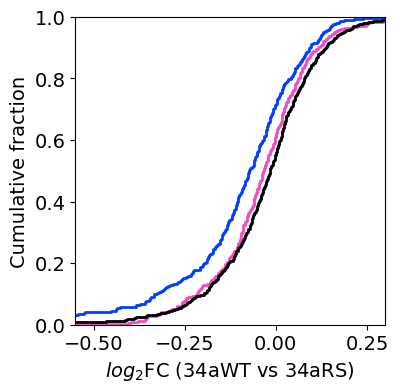

p = 3.9e-15 (ANOVA)

group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0569    0.0  0.0299 0.0838   True
     1      3   0.0681    0.0  0.0485 0.0877   True
     2      3   0.0113 0.5229 -0.0131 0.0356  False


   3P  count
0   3   1094
1   1    526
2   2    293


<Figure size 400x400 with 0 Axes>

In [6]:
subset = data[(data['log2fc WT-NC'] < 0) & (data['FDR WT-NC'] < 0.05)]
x_var = 'log2fc WT-RS'
hue = '3P'
groups = [3, 1, 2]
palette = DIST_PALETTE[:2]+DIST_PALETTE[3:4]

plot.cumulative_hist(
    subset, x=x_var, hue=hue, hue_order=groups, palette=palette,
    xlim=(-0.55, 0.3), xticks=(-0.5, 0.25, 0.25),
    xlabel='$log_{2}$FC (34aWT vs 34aRS)', outfile=FIG_DIR+'6E_01')

model = f_oneway(*[subset[subset[hue] == i][x_var] for i in groups])
print('p =', plot.round_value(model.pvalue, 2), '(ANOVA)\n')

hsd = pairwise_tukeyhsd(endog=subset[x_var], groups=subset[hue], alpha=0.05)
print(*str(hsd.summary()).split('\n')[2:-1], sep='\n')
print('\n')

counts = subset[hue].value_counts().reset_index()
counts.sort_values(hue, key=np.vectorize(groups.index), inplace=True)
print(counts)

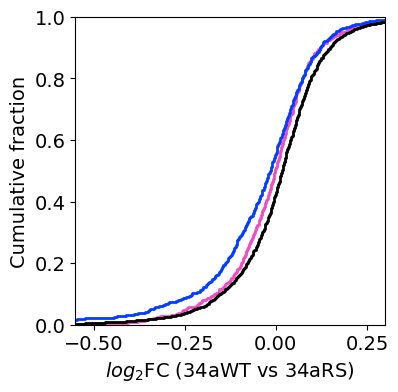

p = 9e-22 (ANOVA)

group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     1      2   0.0292   0.0 0.0134  0.045   True
     1      3   0.0483   0.0 0.0368 0.0598   True
     2      3   0.0191 0.003 0.0054 0.0328   True


   3P  count
0   3   3205
1   1   1172
2   2    750


<Figure size 400x400 with 0 Axes>

In [7]:
x_var = 'log2fc WT-RS'
hue = '3P'
groups = [3, 1, 2]
palette = DIST_PALETTE[:2]+DIST_PALETTE[3:4]

plot.cumulative_hist(
    data, x=x_var, hue=hue, hue_order=groups, palette=palette,
    xlim=(-0.55, 0.3), xticks=(-0.5, 0.25, 0.25),
    xlabel='$log_{2}$FC (34aWT vs 34aRS)', outfile=FIG_DIR+'6E_02')

model = f_oneway(*[data[data[hue] == i][x_var] for i in groups])
print('p =', plot.round_value(model.pvalue, 2), '(ANOVA)\n')

hsd = pairwise_tukeyhsd(endog=data[x_var], groups=data[hue], alpha=0.05)
print(*str(hsd.summary()).split('\n')[2:-1], sep='\n')
print('\n')

counts = data[hue].value_counts().reset_index()
counts.sort_values(hue, key=np.vectorize(groups.index), inplace=True)
print(counts)

## Fig. 6F

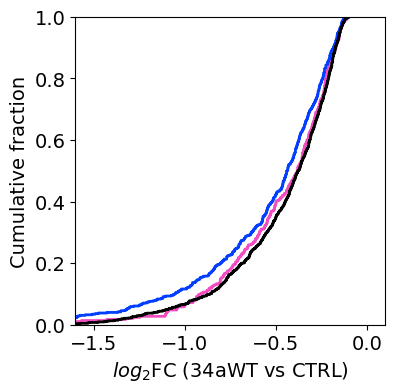

p = 5.9e-06 (ANOVA)

group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0669 0.0132  0.0114 0.1224   True
     1      3   0.0844    0.0   0.044 0.1248   True
     2      3   0.0175 0.6899 -0.0325 0.0676  False


   3P  count
0   3   1094
1   1    526
2   2    293


<Figure size 400x400 with 0 Axes>

In [8]:
subset = data[(data['log2fc WT-NC'] < 0) & (data['FDR WT-NC'] < 0.05)]
x_var = 'log2fc WT-NC'
hue = '3P'
groups = [3, 1, 2]
palette = DIST_PALETTE[:2]+DIST_PALETTE[3:4]

plot.cumulative_hist(
    subset, x=x_var, hue=hue, hue_order=groups, palette=palette,
    xlim=(-1.6, 0.1), xticks=(-1.5, 0, 0.5),
    xlabel='$log_{2}$FC (34aWT vs CTRL)', outfile=FIG_DIR+'6F_01')

model = f_oneway(*[subset[subset[hue] == i][x_var] for i in groups])
print('p =', plot.round_value(model.pvalue, 2), '(ANOVA)\n')

hsd = pairwise_tukeyhsd(endog=subset[x_var], groups=subset[hue], alpha=0.05)
print(*str(hsd.summary()).split('\n')[2:-1], sep='\n')
print('\n')

counts = subset[hue].value_counts().reset_index()
counts.sort_values(hue, key=np.vectorize(groups.index), inplace=True)
print(counts)

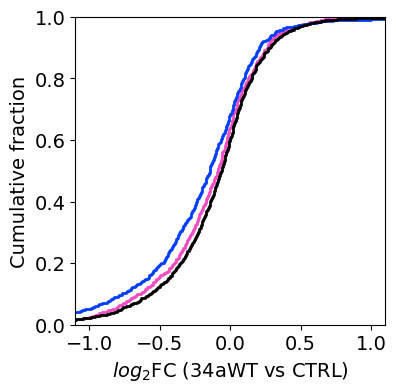

p = 5.2e-14 (ANOVA)

group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0679 0.0006  0.0252 0.1106   True
     1      3    0.104    0.0  0.0729 0.1352   True
     2      3   0.0361 0.0575 -0.0009 0.0732  False


   3P  count
0   3   3205
1   1   1172
2   2    750


<Figure size 400x400 with 0 Axes>

In [9]:
x_var = 'log2fc WT-NC'
hue = '3P'
groups = [3, 1, 2]
palette = DIST_PALETTE[:2]+DIST_PALETTE[3:4]

plot.cumulative_hist(
    data, x=x_var, hue=hue, hue_order=groups, palette=palette,
    xlim=(-1.1, 1.1), xticks=(-1, 1, 0.5),
    xlabel='$log_{2}$FC (34aWT vs CTRL)', outfile=FIG_DIR+'6F_02')

model = f_oneway(*[data[data[hue] == i][x_var] for i in groups])
print('p =', plot.round_value(model.pvalue, 2), '(ANOVA)\n')

hsd = pairwise_tukeyhsd(endog=data[x_var], groups=data[hue], alpha=0.05)
print(*str(hsd.summary()).split('\n')[2:-1], sep='\n')
print('\n')

counts = data[hue].value_counts().reset_index()
counts.sort_values(hue, key=np.vectorize(groups.index), inplace=True)
print(counts)